# Deep-dive into trained models

Recall the high-level structure of NeuralGCM models, from Figure 1 of the 
NeuralGCM paper:

![](./_static/neuralgcm-flowchart.png)

In code, trained models are encapsulated in a
{py:class}`neuralgcm.PressureLevelModel` object, in particular the 
{py:meth}`~neuralgcm.PressureLevelModel.encode`,
{py:meth}`~neuralgcm.PressureLevelModel.decode`
and {py:meth}`~neuralgcm.PressureLevelModel.advance` methods, which
correspond to learned transformations.



## Loading a model

Pre-trained NeuralGCM models can be loaded from checkpoint files saved to disk with the {py:meth}`~neuralgcm.PressureLevelModel.from_checkpoint` constructor, as shown in the {doc}`./inference_demo`. Here we'll use the very small (toy) model distributed as part of the `neuralgcm` Python package:

In [28]:
import jax
import matplotlib.pyplot as plt
import numpy as np
import neuralgcm
import pprint
import xarray

checkpoint = neuralgcm.demo.load_checkpoint_tl63_stochastic()
model = neuralgcm.PressureLevelModel.from_checkpoint(checkpoint)


{doc}`./datasets` describes how to prepare data in detail. Here we'll load testing data already downsampled to the required resolution:

In [15]:
ds = neuralgcm.demo.load_data(model.data_coords)
ds_init = ds.isel(time=0)
inputs, forcings = model.data_from_xarray(ds_init)

## Encoding & decoding data

{py:meth}`~neuralgcm.PressureLevelModel.encode` transforms input data (on pressure levels) into model variables (on sigma levels). To use it, pass in dictionaries of input and forcing data and, for stochastic models, a JAX [RNG key](https://jax.readthedocs.io/en/latest/jax.random.html) used to sample random noise:

In [16]:
encoded = model.encode(inputs, forcings, jax.random.key(0))

{py:meth}`~neuralgcm.PressureLevelModel.decode` can be used to convert back from model levels to pressure levels:

In [17]:
decoded = model.decode(encoded, forcings)

Encoding/decoding is a lossy process, because NeuralGCM's encoded model state uses a different coordinate system. For this model, it introduces about 1 degree of error on average near the surface:

In [18]:
abs(inputs['temperature'][-1] - decoded['temperature'][-1]).mean()

Array(1.264088, dtype=float32)

## Advancing in time

{py:meth}`~neuralgcm.PressureLevelModel.advance` and {py:meth}`~neuralgcm.PressureLevelModel.unroll` allow for stepping encoded model state forward in time, using a combination of NeuralGCM dycore and learned physics.

`advance` steps forward a single time-step in time, of size `model.timestep` (typically 30 or 60 minutes):

In [ ]:
assert model.timestep == np.timedelta64(1, 'h')
advanced = model.advance(encoded, forcings)

{py:meth}`~neuralgcm.PressureLevelModel.unroll` is the higher-level method for stepping forward multiple steps at once, with post-processing outputs at a given time interval:

In [ ]:
all_forcings = model.forcings_from_xarray(ds)
advanced, outputs = model.unroll(encoded, all_forcings, steps=4, timedelta=np.timedelta64(1, 'h'))

Unlike forcings on `encoded`, `decode` and `advance`, the forcings argument to `unroll` should include a leading dimension. At each model time-step, the nearest forcing data in time is used to advance in time, which allows for controlling how forcings get updated over the course of a long time integration:

- For persistence forcings (i.e., to keep sea surface temperature and sea ice concentration constant over the forecast period), simply supply a dataset with a `time` dimension of size 1, corresponding to the initial conditions.
- For dynamic forcings, pass in a dataset to {py:meth}`~neuralgcm.PressureLevelModel.forcings_from_xarray` that changes over time at the desired time granularity. ERA5's sea surface temperature and sea ice concentration variables exclude the diurnal cycle and are updated only about once daily, so passing in hourly forcings is unnecessary.

The `advanced` state is the updated encoded state after taking all of the indicated time-steps (4 hours in this case), which could be fed back into `unroll` advance further in time. This allows for making very long time integrations without running out of memory, e.g., something like:

```python
t0 = np.datetime64(...)
inputs, forcings = model.data_from_xarray(ds.sel(time=t0))
state = model.encode(inputs, forcings, jax.random.key(0))

dt = np.timedelta(24, 'h')  # save outputs once per day
weeks = 52  # forecast one year in total
steps = 7  # forecast one week at a time

for w in range(weeks):
    t = t0 + w * steps * dt
    forcings = model.forcings_from_xarray(ds.sel(time=t))  # update forcings
    state, outputs = model.unroll(state, forcings, steps=steps, timedelta=dt)
    # save outputs to disk
```


```{note}
There is currently no public API for separating tendencies from dynamics and learned physics.
```

## JAX transformations (jit, grad, etc)

{py:class}`neuralgcm.PressureLevelModel` objects are [JAX pytrees](https://jax.readthedocs.io/en/latest/pytrees.html), where the leaves are the learnable neural network parameters.

This means you can compose NeuralGCM models with all of JAX's powerful transformations such `jit`, `grad` and `vmap`. Here's a simple example of fine-tuning our toy model with [Optax](https://optax.readthedocs.io/) to reduce reconstruction error:

In [21]:
import jax
import optax

@jax.jit
def compute_loss(model, inputs, forcings, rng):
    encoded = model.encode(inputs, forcings, rng_key=rng)
    restored = model.decode(encoded, forcings)
    return abs(inputs['temperature'] - restored['temperature']).mean()

In [22]:
compute_loss(model, inputs, forcings, jax.random.key(0))

Array(6.2256584, dtype=float32)

In [23]:
optimizer = optax.adam(1e-3)
opt_model = model
opt_state = optimizer.init(model)
for i in range(5):
    loss, grads = jax.value_and_grad(compute_loss)(
        opt_model, inputs, forcings, jax.random.key(0)
    )
    updates, opt_state = optimizer.update(grads, opt_state)
    opt_model = optax.apply_updates(opt_model, updates)
    print(f'{i=}, {loss=}')

i=0, loss=Array(6.2256584, dtype=float32)
i=1, loss=Array(4.670498, dtype=float32)
i=2, loss=Array(3.855668, dtype=float32)
i=3, loss=Array(3.5485578, dtype=float32)
i=4, loss=Array(3.4335625, dtype=float32)


## Encoded model state

```{warning}
There are no stable API guarantees for encoded model state, beyond the data being guaranteed to be a [JAX pytree](https://jax.readthedocs.io/en/latest/pytrees.html). Expect different models (especially in future versions of NeuralGCM) to store state in different ways.
```

Model state is big, so we'll only look at shapes:

In [24]:
pprint.pprint(jax.tree.map(np.shape, encoded))

ModelState(state=StateWithTime(vorticity=(32, 128, 65),
                               divergence=(32, 128, 65),
                               temperature_variation=(32, 128, 65),
                               log_surface_pressure=(1, 128, 65),
                               sim_time=(),
                               tracers={'specific_cloud_ice_water_content': (32,
                                                                             128,
                                                                             65),
                                        'specific_cloud_liquid_water_content': (32,
                                                                                128,
                                                                                65),
                                        'specific_humidity': (32, 128, 65)}),
           memory=None,
           diagnostics={},
           randomness=RandomnessState(core=(10, 128, 65),
                       

Internally, model state is represented using a different set of variables (vorticity, divergence, temperature variation and log surface pressure) more appropriate to NeuralGCM's spectral dynamical core. Each variable is stored vertically on sigma levels and horizontally as spherical harmonic coefficients, and using Dinosaur's internal non-dimensional units rather than SI units.

We can convert back using utility methods from Dinosaur and NeuralGCM:

In [25]:
from dinosaur import spherical_harmonic

nodal_vorticity = model.model_coords.horizontal.to_nodal(encoded.state.vorticity)
nodal_divergence = model.model_coords.horizontal.to_nodal(encoded.state.divergence)

nodal_u_wind, nodal_v_wind = spherical_harmonic.vor_div_to_uv_nodal(
    model.model_coords.horizontal,
    encoded.state.vorticity,
    encoded.state.divergence,
)

encoded_ds = model.data_to_xarray(
    {
        'vorticity': model.from_nondim_units(nodal_vorticity, '1/s'),
        'divergence': model.from_nondim_units(nodal_divergence, '1/s'),
        'u_wind': model.from_nondim_units(nodal_u_wind, 'm/s'),
        'v_wind': model.from_nondim_units(nodal_v_wind, 'm/s'),
    },
    times=None,
    decoded=False,
)

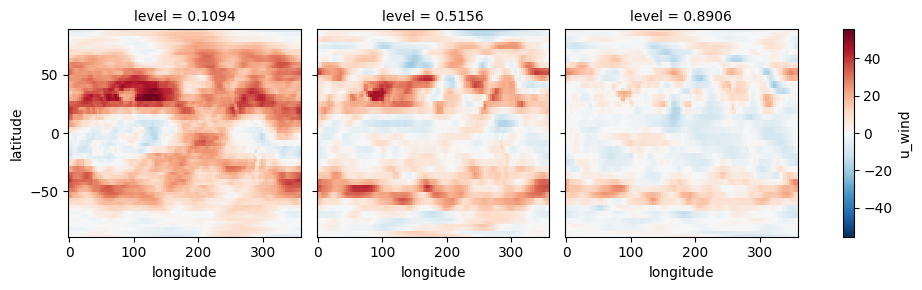

In [26]:
encoded_ds.u_wind.sel(level=[0.1, 0.5, 0.9], method='nearest').plot.imshow(
    x='longitude', y='latitude', col='level',
);

You can also work with state in the spherical harmonic (modal) representation, which is sometimes convenient, e.g., for calculating power spectra. Here care should be taken to ensure that structural sparsity is handled properly, because many of the entries in these arrays are always fixed at zero:

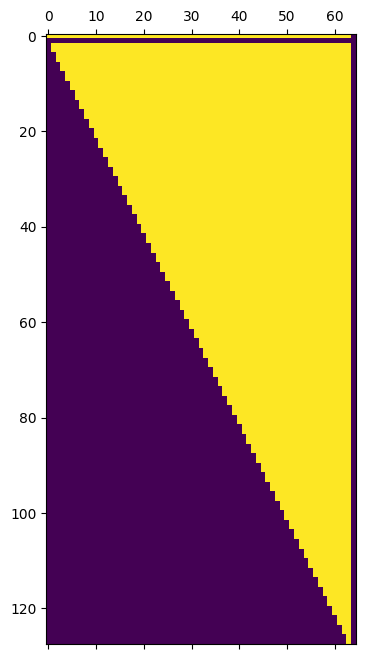

In [29]:
plt.matshow(encoded.state.temperature_variation[0] != 0);

The non-zero mask can be accessed programmatically:

In [30]:
model.model_coords.horizontal.mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False,  True,  True]])

For more details, see the [source code](https://github.com/google-research/dinosaur/blob/main/dinosaur/spherical_harmonic.py) for spherical harmonics in Dinosaur.

## Random noise

NeuralGCM stochastic models use JAX's [deterministic and explicit random number generation](https://jax.readthedocs.io/en/latest/jax.random.html).

You can control noise via the `rng_key` argument in {py:meth}`~neuralgcm.PressureLevelModel.encode`, which is optional for deterministic models. To make multiple stochastic forecasts (as many as desired), simply pass in different RNG keys, e.g.,

In [31]:
encoded = model.encode(inputs, forcings, jax.random.key(0))
encoded2 = model.encode(inputs, forcings, jax.random.key(1))

In [32]:
# slightly different average temperatures
encoded.state.temperature_variation.mean(), encoded2.state.temperature_variation.mean()

(Array(-0.00401366, dtype=float32), Array(-0.00391874, dtype=float32))

Randomness in the learned physics is also controlled via the same `rng_key` argument, which initializes an RNG key on the model state. You can visualize the Gaussian random fields:

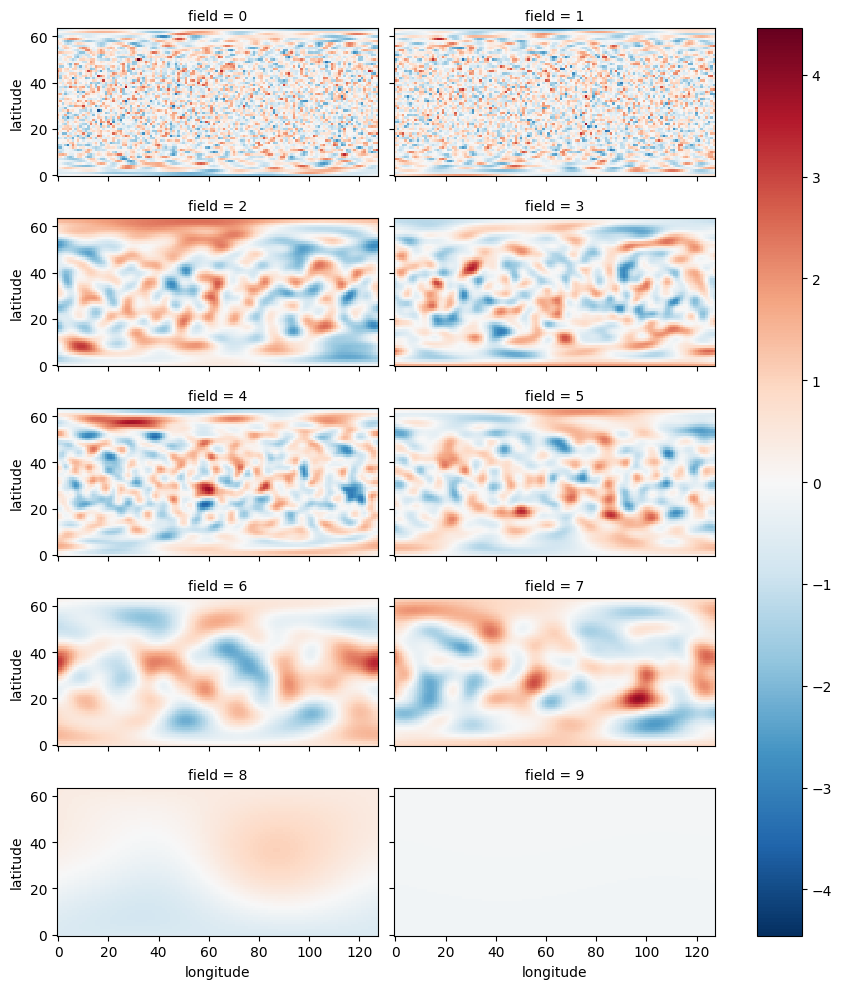

In [33]:
xarray.DataArray(
    encoded.randomness.nodal_value,
    dims=['field', 'longitude', 'latitude'],
).plot(x='longitude', y='latitude', col='field', col_wrap=2, aspect=2, size=2);

Adjusting random noise on an existing model state is also possible (on current stochastic NeuralGCM models) by replacing  `encoded.randomness.rng_key`, e.g., 

In [34]:
encoded_with_new_rng = encoded.replace(randomness=encoded.randomness.replace(prng_key=jax.random.key(123)))

These fields will slowly diverge after advancing in time due to new noise being injected at each time step:

In [ ]:
advanced_with_new_rng = model.advance(encoded_with_new_rng, forcings)

In [36]:
advanced.state.temperature_variation.mean(), advanced_with_new_rng.state.temperature_variation.mean()

(Array(-0.00416081, dtype=float32), Array(-0.00420048, dtype=float32))